# Smoke detection

This project had been created using Unet as an architecture and Resnet as a backbone.

# Dependencies

In [1]:
import os
import config

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam

import segmentation_models as sm
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from keras import backend as K
import tqdm
import PIL

Using TensorFlow backend.


Segmentation Models: using `keras` framework.



Bad key "text.kerning_factor" on line 4 in
/home/adrien/anaconda3/envs/cpu/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Functions 

Some functions used during this project

In [2]:
def get_data(batch_origin, batch_mask, size = config.BATCH_SIZE):
    '''
    input: list of strings with the name of the images
    output: two Tensors (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL) for the original picture and the mask
    '''
    X = np.zeros((size, config.IMG_SIZE, config.IMG_SIZE, 3), dtype=np.float32)
    y = np.zeros((size, config.IMG_SIZE, config.IMG_SIZE, 1), dtype=np.float32)

    for i, img in enumerate(batch_origin):
        x_img = load_resize(img)
        X[i] = x_img
    for i, img in enumerate(batch_mask):
        x_img = load_resize(img)
        y[i] = x_img
    return X, y

In [3]:
def load_resize(img_name):
    '''
    input: a string of the file name of the image 
    output: a tensor (IMG_SIZE, IMG_SIZE, CHANNEL)
    '''


    img = Image.open(config.DATA_PATH + '/' + img_name)
    img = img.resize((config.IMG_SIZE, config.IMG_SIZE), PIL.Image.ANTIALIAS)
    img = np.array(img)
    img = np.divide(img,255.)
    if 'mask' in img_name:
        img = np.expand_dims(img, axis=-1)  # for the mask (128,128) to (128,128,1)
    return img


In [4]:
def iou_coef(y_true, y_pred, i, smooth=1):
    '''
    input: two mask tensors (IMG_SIZE, IMG_SIZE, 1)
    output: the IoU score
    '''
    y_b = y[i].squeeze()
    y_b = (tf.math.greater(y_b,0.5))
    y_b = y_b.numpy()
    y_b = y_b.astype(int)
    y_pred_b = y_pred[i].squeeze()
    y_pred_b = (tf.math.greater(y_pred,0.2))
    y_pred_b = y_pred_b.numpy()
    y_pred_b = y_pred_b.astype(int)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [6]:
def apply_threshold(mask, threshold):
    '''
    input: a mask (IMG_SIZE, IMG_SIZE, 1) and the threshold to apply (0.0 to 1.0)
    output: a binary mask (IMG_SIZE, IMG_SIZE, 1)
    '''
    mask = (tf.math.greater(mask,threshold))
    mask= mask.numpy()
    mask = mask.astype(int)
    return mask

In [7]:
def my_image_mask_generator(image_data_generator, mask_data_generator):
    '''
    Zip two generator together 
    '''
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask)


In [8]:
def visualize (x, y, y_pred,threshold = 0.8, n = config.BATCH_SIZE):
    '''
    Input: 
    x: Tensor of original images (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)
    y: Tensor of original masks (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1)
    y_pred: Tensor of predicted masks (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1) 
    threshold: threshold to apply (default 0.8)
    n: number of row to plot (default BATCH_SIZE)
    
    output:
    plot of the inputs
    '''

    fig, ax = plt.subplots(n, 4, figsize=(10, 20))
    fig.suptitle("Inference for random images 512px", fontsize=16)

    for i in range(n):
        ax[i, 0].set_xticks([])
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 0].imshow(x[i].squeeze())
        ax[i, 0].set_title('image' + str(i), fontsize=10)
        ax[i, 1].imshow(y[i].squeeze())
        ax[i, 1].set_title("original mask", fontsize=10)
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
        ax[i, 2].imshow(y_pred[i].squeeze())
        ax[i, 2].set_title("predicted output", fontsize=10)
        ax[i, 2].set_xticks([])
        ax[i, 2].set_yticks([])
        mask = apply_threshold(y_pred[i],threshold)
        ax[i, 3].imshow(mask.squeeze())
        ax[i, 3].set_title(f"treshold output {threshold}", fontsize=10)
        ax[i, 3].set_xticks([])
        ax[i, 3].set_yticks([])
        IoU = sm.metrics.IOUScore(threshold=threshold)(y[i],y_pred[i])
        IoU = (IoU.numpy())
        ax[i, 3].set_xlabel(f'IoU score: {np.around(IoU,decimals = 2)}')
    plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()

In [9]:
def load_file(path):
    """

    :return: return list of string files from folder
    """
    files = os.listdir(path)
    return files

# Initialize generators

Training generator initialization

In [10]:
#one for the mask one for the images. Rescale to normalize

image_datagen = ImageDataGenerator(rescale=1.0/255.0)
mask_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [11]:
seed = 1
image_generator = image_datagen.flow_from_directory(
    'data/train/origins',
    class_mode=None,
    seed=seed,
    batch_size= config.BATCH_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE),
    color_mode= 'rgb')
mask_generator = mask_datagen.flow_from_directory(
    'data/train/masks',
    class_mode=None,
    seed=seed,
    batch_size= config.BATCH_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE),
    color_mode="grayscale")

#Zipping them together
train_generator = my_image_mask_generator(image_generator,mask_generator)

Found 4452 images belonging to 1 classes.
Found 4452 images belonging to 1 classes.


Validation generator initialization

In [12]:
val_image_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_mask_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [13]:
seed = 50
val_image_generator = val_image_datagen.flow_from_directory(
    'data/validation/origins',
    class_mode=None,
    seed=seed,
    batch_size= config.VAL_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE))
val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/validation/masks',
    class_mode=None,
    seed=seed,
    batch_size= config.VAL_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE),
    color_mode="grayscale")
# combine generators into one which yields image and masks
val_generator = my_image_mask_generator(val_image_generator,val_mask_generator)

Found 1509 images belonging to 1 classes.
Found 1509 images belonging to 1 classes.


# Training Model

In [ ]:
#getting the number of images

list_train = load_file('data/train/origins/images')
list_val = load_file('data/validation/origins/images')
print (len(list_train))
print (len(list_val))

In [ ]:
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, activation = 'sigmoid', encoder_weights=None)
model.compile(
    optimizer = Adam(0.0001),
    loss=sm.losses.binary_crossentropy,
    metrics=[sm.metrics.IOUScore(threshold=0.6, per_image = True),
             sm.metrics.Recall(threshold=0.6, per_image = True),
             sm.metrics.Precision(threshold=0.6, per_image = True)],
)

In [ ]:
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('weight-Unet.h5', verbose=1, save_weights_only=True),
    CSVLogger('log-Unet.log', append = True),
    TensorBoard(log_dir='./Graph-unet', histogram_freq=0, write_graph=True, write_images=True)
]

In [ ]:
results = model.fit_generator(train_generator,
                    steps_per_epoch=len(list_train) // config.BATCH_SIZE,
                    validation_data= val_generator,
                    validation_steps= len(list_val) // config.VAL_SIZE,
                    epochs=15,
                    callbacks = callbacks)

# Testing data

Initializing test generator

In [15]:
image_datagen = ImageDataGenerator(rescale=1.0/255.0)
mask_datagen = ImageDataGenerator(rescale=1.0/255.0)
image_generator = image_datagen.flow_from_directory(
    'data/test/origins',
    class_mode=None,
    seed=1,
    batch_size= config.BATCH_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE),
    color_mode= 'rgb')
mask_generator = mask_datagen.flow_from_directory(
    'data/test/masks',
    class_mode=None,
    seed=1,
    batch_size= config.BATCH_SIZE,
    target_size=(config.IMG_SIZE,config.IMG_SIZE),
    color_mode="grayscale")
test_generator = my_image_mask_generator(image_generator,mask_generator)
my_test_generator = iter(test_generator)

Found 1509 images belonging to 1 classes.
Found 1509 images belonging to 1 classes.


In [14]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, activation = 'sigmoid', encoder_weights=None)
model.compile(
    optimizer = Adam(0.0001),
    loss=sm.losses.binary_crossentropy,
    metrics=[sm.metrics.IOUScore(threshold=0.5, per_image = True),sm.metrics.Recall(threshold=0.5, per_image = True),sm.metrics.Precision(threshold=0.5, per_image = True)],
)

#loading weights 
model.load_weights('weight-URes-256px_BCElossv12.h5')

In [16]:
(x,y)=next(my_test_generator)

In [17]:
y_pred = model.predict(x)

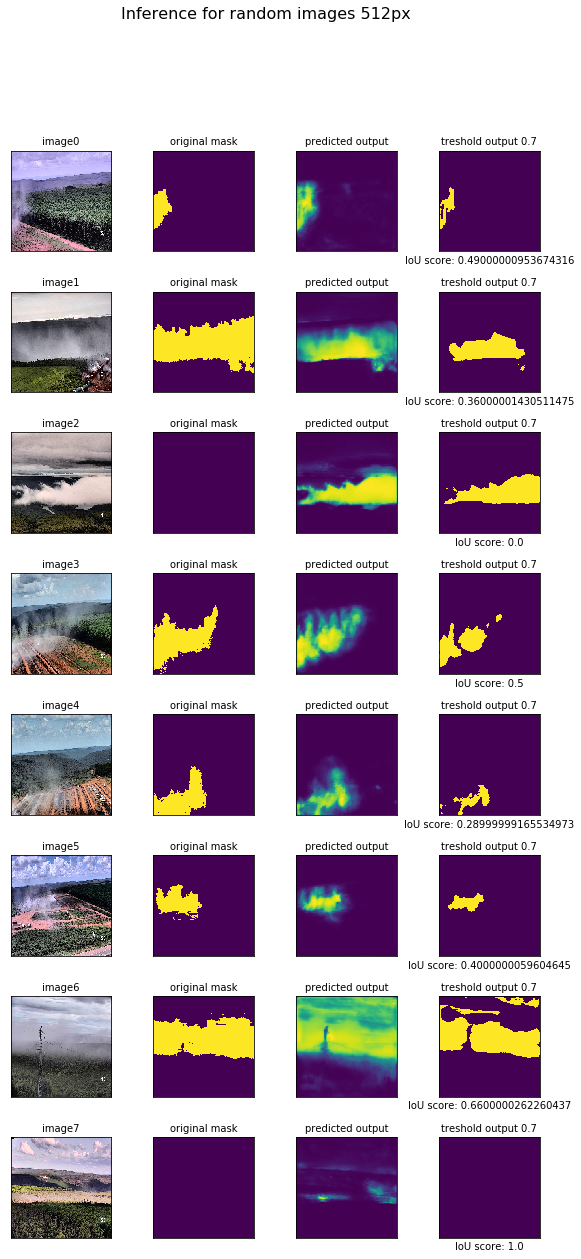

In [18]:
visualize(x,y,y_pred,0.7)

## Evaluating metrics from test set

In [19]:

model.evaluate_generator(my_test_generator, steps = 20)


[0.05547608062624931,
 0.5853496789932251,
 0.7237670421600342,
 0.8134117126464844]

## Plotting Metrics and Losses

In [20]:
###Reading the CSV saved with the callbacks###

df = pd.read_csv('training_BCElossv12.log')
df.set_index('epoch', inplace = True)
df.columns

Index(['iou_score', 'loss', 'precision', 'recall', 'val_iou_score', 'val_loss',
       'val_precision', 'val_recall'],
      dtype='object')

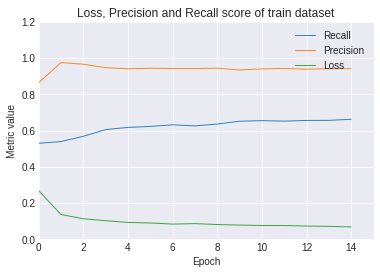

In [28]:
###Plotting training dataset metrics and loss###

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
#plt.plot(df.index, df.iou_score, marker='', linewidth=1, alpha=0.9, label='iou')
plt.plot(df.index, df.recall, marker='', linewidth=1, alpha=0.9, label='Recall')
plt.plot(df.index, df.precision, marker='', linewidth=1, alpha=0.9, label='Precision')
plt.plot(df.index, df.loss, linewidth=1, alpha=0.9, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Loss, Precision and Recall score of train dataset')
plt.axis((0,15,0,1.2))
plt.legend()
plt.show()

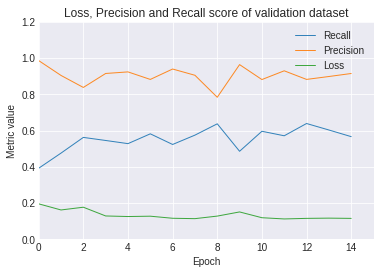

In [27]:
###Plotting Validation metrics and loss###

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
#plt.plot(df.index, df.iou_score, marker='', linewidth=1, alpha=0.9, label='iou')
plt.plot(df.index, df.val_recall, marker='', linewidth=1, alpha=0.9, label='Recall')
plt.plot(df.index, df.val_precision, marker='', linewidth=1, alpha=0.9, label='Precision')
plt.plot(df.index, df.val_loss, linewidth=1, alpha=0.9, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Loss, Precision and Recall score of validation dataset')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,15,0,1.2))
plt.show()

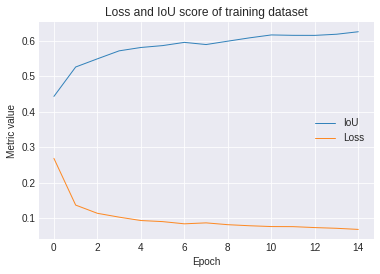

In [26]:
### Plotting IoU from training dataset###

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.plot(df.index, df.iou_score, marker='', linewidth=1, alpha=0.9, label='IoU')
plt.plot(df.index, df.loss, linewidth=1, alpha=0.9, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Loss and IoU score of training dataset')
plt.legend()
plt.show()

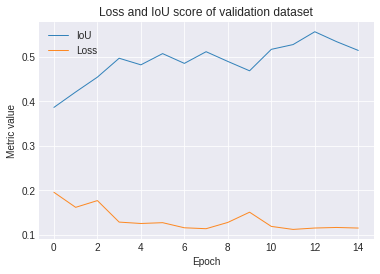

In [25]:
### Plotting IoU from validation dataset###

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.plot(df.index, df.val_iou_score, marker='', linewidth=1, alpha=0.9, label='IoU')
plt.plot(df.index, df.val_loss, linewidth=1, alpha=0.9, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric value')
plt.title('Loss and IoU score of validation dataset')
plt.legend()
plt.show()